# Equilibrium Binding of Transcription Factors
> If you know TF concentrations, binding site affinities, and cooperativities, can you predict probabilities for each configuration?

- toc: true
- comments: true
- hide: false

In [2]:
#collapse
# imports
import string
from random import choice, random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from matplotlib.colors import colorConverter, TABLEAU_COLORS
# colorConverter.to_rgba('mediumseagreen', alpha=.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('svg')

plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['figure.dpi'] = 140
plt.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['hatch.linewidth'] = 0.3

## Background & Motivation

At the moment, there does not exist an assay which reports directly on the occupancies of transcription factor binding sites across the genome in single cells. However, we can measure chromatin accessibility in single cells via [single-cell ATAC-seq](https://www.10xgenomics.com/products/single-cell-atac), which reports a 1-dimensional projection of TFBS occupancies. This blog post explores an approach to lift single cell ATAC signals onto the space of TFBS occupancies, i.e. to deconvolve ATAC signals into TF binding tracks. 

Our approach relies on an orthogonal suite of experiments characterizing transcription factor binding in vitro. In [High-Throughput SELEX](https://genome.cshlp.org/content/20/6/861.long) experiments, the...

## Equilibrium Binding Model

There exist two mathematical formalisms to describe the probabilities of molecular configurations at equilibrium: thermodynamics and kinetics. The kinetics formalism is more general: it describes a system's trajectory to equilibrium, and can describe non-equilibrium systems. Tthe thermodynamics formalism only describes equilibrium, but requires fewer parameters to do so. We'll derive an expression for the probability of a single TFBS' occupancy with both formalisms, but drop the kinetic description for more elaborate configurations. 

### Single TF

$$\newcommand{\kon}{k_{\mathrm{on}}}
\newcommand{\koff}{k_{\mathrm{off}}}$$

Most derivations of the probability of TFBS occupancy at equilibrium employ a kinetics formalism, so we'll walk through that first, and then explore the analog in the thermodynamics description. In the kinetic description, the parameters are **rates**. 

$$ \mathrm{TF} + \mathrm{TFBS} \underset{\koff}{\overset{\kon}{\rightleftarrows}} \mathrm{TF\colon TFBS} $$

> Note: We will assume the [Law of Mass Action](https://en.wikipedia.org/wiki/Law_of_mass_action) for well-mixed solutions throughout. 


The natural rates are the rate of TF binding $\kon$ and unbinding $\koff$. Equilibrium is reached when binding and unbinding are balanced:

$$\frac{d[\mathrm{TF\colon TFBS}]}{dt} = k_{\mathrm{on}}[\mathrm{TF}][\mathrm{TFBS}] - k_{\mathrm{off}}[\mathrm{TF\colon TFBS}] = 0 \text{ at equilibrium}$$
$$k_{\mathrm{on}}[\mathrm{TF}]_{\mathrm{eq}}[\mathrm{TFBS}]_{\mathrm{eq}} = k_{\mathrm{off}}[\mathrm{TF\colon TFBS}]_{\mathrm{eq}}$$
$$\text{(dropping eq subscript) }[\mathrm{TF\colon TFBS}] = \frac{k_{\mathrm{on}}[\mathrm{TF}][\mathrm{TFBS}]}{k_{\mathrm{off}}} = \frac{[\mathrm{TF}][\mathrm{TFBS}]}{k_{d}}$$

where $k_{d} = \frac{\koff}{\kon}$ is called the [dissociation constant](https://en.wikipedia.org/wiki/Dissociation_constant) (or equilibrium constant). We'd like to determine the probability of finding the TFBS occupied, i.e. the fraction of time it spends in the bound state. That fraction is $\frac{[\mathrm{bound}]}{([\mathrm{unbound}] + [\mathrm{bound}])} = \frac{[\mathrm{TF\colon TFBS}]}{([\mathrm{TFBS}] + [\mathrm{TF\colon TFBS}])}$. Define the denominator as $[\mathrm{TFBS}]_{0} = [\mathrm{TFBS}] + [\mathrm{TF\colon TFBS}]$ so that $[\mathrm{TFBS}] = [\mathrm{TFBS}]_{0} - [\mathrm{TF\colon TFBS}]$ and substitute: 

$$[\mathrm{TF\colon TFBS}] = \frac{[\mathrm{TF}]([\mathrm{TFBS}]_{0} - [\mathrm{TF\colon TFBS}])}{k_{d}}$$
$$[\mathrm{TF\colon TFBS}](k_d + [\mathrm{TF}]) = [\mathrm{TF}][\mathrm{TFBS}]_{0}$$
$$\frac{[\mathrm{TF\colon TFBS}]}{[\mathrm{TFBS}]_{0}} = \frac{[\mathrm{TF}]}{k_d + [\mathrm{TF}]}$$

> Note: We could also ask for this expression in terms of $[\mathrm{TF}]_0 = [\mathrm{TF}] + [\mathrm{TF\colon TFBS}]$ however, since we're considering a single TFBS, $[\mathrm{TF\colon TFBS}]$ is at most 1, and so $[\mathrm{TF}]_0 \approx [\mathrm{TF}]$. In instances of ligand-receptor binding in which that approximation cannot be made, the fraction bound is a messy quadratic. [Derivation here](https://www.med.upenn.edu/ostaplab/assets/user-content/documents/simpleligandbindingequations.pdf). 


In the thermodynamic description, the parameters are Gibbs free energies $\Delta G$. Let's follow the derivation from [Physical Biology of the Cell](http://www.rpgroup.caltech.edu/pboc2/) (pp. 242) and consider the number microstates underlying each of the of bound and unbound macrostates, and their energies.

In order to count microstates, we imagine distributing $L$ TF molecules across a space-filling lattice with $\Omega$ sites. The energy of a TF in solution is $\varepsilon_{\mathrm{solution}}$ and the energy of a bound TF is $\varepsilon_{\mathrm{bound}}$. $\beta$ is the constant $1/k_b T$ where $k_b$ is Boltzmann's constant and $T$ is the temperature. 

<img src="../data/equilibrium_TFs/single_TF_thermodynamic.png" width=1000/>

In our case, the number of microstates in the unbound macrostate is $\frac{\Omega !}{L!(\Omega -L)!}\approx \frac{\Omega^L}{L!}$ and they each have energy $L \cdot \varepsilon_s$. The number of microstates in the bound macrostate is $\frac{\Omega !}{(L-1)!(\Omega -(L+1))}\approx \frac{\Omega^{(L-1)}}{(L-1)!}$ and they each have energy $(L-1) \varepsilon_s + \varepsilon_b$.

The [Boltzmann distribution](https://en.wikipedia.org/wiki/Boltzmann_distribution) describes the probability of a microstate as a function of its energy: $p(E_i) = e^{-\beta E_i}/Z$ where $Z$ is the "partition function" or simply $\sum_i e^{-\beta E_i}$ the sum of the weights of the microstates, which normalizes the distribution. In our case:


$$Z(L,\Omega)=\left(\colorbox{LightCyan}{$ \frac{\Omega^L}{L!} e^{-\beta L \varepsilon_s}$}\right) + \left(\colorbox{Seashell}{$\frac{\Omega^{(L-1)}}{(L-1)!} e^{-\beta [(L-1) \varepsilon_s + \varepsilon_b]}$}\right)$$

With that expression in hand, we can express the probability of the bound macrostate, $p_b$:

$$p_b=\frac{ \colorbox{Seashell}{$\frac{\Omega^{(L-1)}}{(L-1)!} e^{-\beta [(L-1) \varepsilon_s + \varepsilon_b]}$}}{\colorbox{LightCyan}{$\frac{\Omega^L}{L!} e^{-\beta L \varepsilon_s}$} + \colorbox{Seashell}{$\frac{\Omega^{(L-1)}}{(L-1)!} e^{-\beta [(L-1) \varepsilon_s + \varepsilon_b]}$}} \cdot \color{DarkRed}\frac{\frac{\Omega^L}{L!}e^{\beta L \varepsilon_s}}{\frac{\Omega^L}{L!}e^{\beta L \varepsilon_s}} \color{black} = \frac{(L/\Omega)e^{- \beta \Delta \varepsilon}}{1+(L/\Omega)e^{- \beta \Delta \varepsilon}}  $$

Where we have defined $\Delta \varepsilon = \varepsilon_b - \varepsilon_s$. $L/\Omega$ is really just the concentration $[\mathrm{TF}]$, which leaves us with an expression suspiciously similar to the one we derived from the kinetics formalism:

$$p_b = \frac{[\mathrm{TF}]e^{-\beta \Delta \varepsilon}}{1+[\mathrm{TF}]e^{-\beta \Delta \varepsilon}} \cdot \color{DarkRed}\frac{e^{\beta \Delta \varepsilon}}{e^{\beta \Delta \varepsilon}} \color{black} = \frac{[\mathrm{TF}]}{e^{\beta \Delta \varepsilon}+[\mathrm{TF}]}$$

From which we recapitulate an important correspondence between kinetics and thermodynamics at equilibrium: $ k_d = e^{\beta \Delta \varepsilon} = e^{\Delta \varepsilon / k_bT} $ more commonly written for different units as $k = e^{-\Delta G / RT}$.

The takeaway is that both the kinetic and thermodynamic formalisms produce an equivalent expression for the probabilities of each of the bound and unbound configurations, parameterized respectively by $k_d$ and $\Delta G$.

**References**: 
- [Physical Biology of the Cell](http://www.rpgroup.caltech.edu/pboc2/)
- [Thermodynamics of Biological Processes](https://doi.org/10.1016/B978-0-12-381268-1.00014-8)
- [Statistical Mechanics of Binding](http://www.bio-physics.at/wiki/index.php?title=Statistical_Mechanics_of_Binding)

### Direct Cooperativity

Suppose now that two TFs bind adjacent segments of DNA in such a way that the binding of either facilitates the binding of the other. We call this direct cooperativity. 

As before, we enumerate the configurations, their multiplicities, and their energies. We'll call the TFs A and B. We'll denote their counts as $A$ and $B$. The energy of a TF in solution will once more be $A_s$ and bound to its cognate TFBS $A_b$. The energy of cooperativity will be $C_{AB}$.

<table style="float:left; width:100%">
    <tr style="text-align:center; font-size:1.5rem; font-family:serif"><td>State</td><td>Energy</td><td>Multiplicity</td><td>Weight</td></tr>
    <tr><td><img src='../data/equilibrium_TFs/naked.png'  width=300/></td>
        <td>$A \cdot A_s + B \cdot B_s$</td>
        <td>$\frac{\Omega!}{(\Omega - A - B)!A!B!} \approx \frac{\Omega^{A+B}}{A!B!}$</td>
        <td>$\frac{\Omega^{A+B}}{A!B!} \cdot e^{-\beta \left[ A \cdot A_s + B \cdot B_s \right]}$</td>
    </tr>
    <tr><td><img src='../data/equilibrium_TFs/A.png'  width=300/></td>
        <td>$(A - 1) A_s + A_b + B \cdot B_s$</td>
        <td>$\frac{\Omega!}{(\Omega - (A - 1) - B)!(A-1)!B!} \approx \frac{\Omega^{A+B-1}}{(A-1)!B!}$</td>
        <td>$\frac{\Omega^{A+B-1}}{(A-1)!B!} \cdot e^{-\beta \left[ (A - 1) A_s + A_b + B \cdot B_s \right]}$</td>
    </tr>
    <tr><td><img src='../data/equilibrium_TFs/B.png'  width=300/></td>
        <td>$A \cdot A_s + (B - 1) B_s + B_b$</td>
        <td>$\frac{\Omega!}{(\Omega - A - (B - 1))!A!(B-1)!} \approx \frac{\Omega^{A+B-1}}{A!(B-1)!}$</td>
        <td>$\frac{\Omega^{A+B-1}}{A!(B-1)!} \cdot e^{-\beta \left[ A \cdot A_s + (B - 1) B_s + B_b \right]}$</td>
    </tr>
    <tr><td><img src='../data/equilibrium_TFs/AB.png' width=300 /></td>
        <td>$(A - 1) A_s + A_b + (B - 1) B_s + B_b + C_{AB}$</td>
        <td>$\frac{\Omega!}{(\Omega - (A - 1) - (B-1))!(A-1)!(B-1)!} \approx \frac{\Omega^{A+B-2}}{(A-1)!(B-1)!}$</td>
        <td>$\frac{\Omega^{A+B-2}}{(A-1)!(B-1)!} \cdot e^{-\beta \left[ (A - 1) A_s + A_b + (B - 1) B_s + B_b + C_{AB} \right]}$</td>
    </tr>
</table>

The partition function is the sum of the weights:

$$ Z = \frac{\Omega^{A+B}}{A!B!} \cdot e^{-\beta \left[ A \cdot A_s + B \cdot B_s \right]} +
\frac{\Omega^{A+B-1}}{(A-1)!B!} \cdot e^{-\beta \left[ (A - 1) A_s + A_b + B \cdot B_s \right]} +
\frac{\Omega^{A+B-1}}{A!(B-1)!} \cdot e^{-\beta \left[ A \cdot A_s + (B - 1) B_s + B_b \right]} +
\frac{\Omega^{A+B-2}}{(A-1)!(B-1)!} \cdot e^{-\beta \left[ (A - 1) A_s + A_b + (B - 1) B_s + B_b + C_{AB} \right]}$$

Which we can greatly simplify by multiplying the entire expression by the reciprocal of the "base state" weight, $\color{DarkRed}\frac{A!B!}{\Omega^{A+B}} \cdot e^{\beta \left[ A \cdot A_s + B \cdot B_s \right]}$, normalizing that weight to 1:

$$ Z = 1 +
\frac{A}{\Omega} \cdot e^{-\beta \left[ A_b-A_s \right]} +
\frac{B}{\Omega} \cdot e^{-\beta \left[ B_b-B_s \right]} +
\frac{A \cdot B}{\Omega^2} \cdot e^{-\beta \left[ A_b-A_s+B_b-B_s+C_{AB} \right]}$$

Taking the definition $[A] = A/\Omega$ and $\Delta G_A = A_b-A_s$ produces: 

$$ Z = 1 +
[A] e^{-\beta \left[ \Delta G_A \right]} +
[B] e^{-\beta \left[ \Delta G_B \right]} +
[A][B] e^{-\beta \left[ \Delta G_A+\Delta G_B+C_{AB} \right]}$$

Then the probability of any state is just the weight of that state divided by the partition function expression $Z$. 

However, we notice a problem with extending this approach to realistic TF occupancy configurations: the number of configurations grows exponentially in the number of transcription factor binding sites ($2^{|\mathrm{TFBS}|}$). Only 20 Transcription Factor Binding sites entails ~1 million configurations, and as many terms in the denominator of the probability expression. Computing probabilities of configurations exactly then becomes intractable for realistic scenarios; we need to estimate these probabilities by sampling. 

In the MCMC approach, we only need to evaluate numerators, i.e. the un-normalized probabilities of configurations. It's worth noting here that the computational effort involved is already substantial: the number of terms in the weight grows ~linearly with the number of TFBS, which could grow quite large. 

Our general formula for the un-normalized probability of a configuration, considering only cooperative interactions is:

$$ p_{\mathrm{config}} =  \prod_{i \in \, \mathrm{bound \,TBFS}} \left( [\mathrm{TF}_{\mathrm{cognate}(i)}] \cdot e^{-\beta \left[ \Delta G_i + \sum_j c_{ij} \right]}  \right)$$

$$ \log(p_{\mathrm{config}}) = \sum_{i \in \, \mathrm{bound \,TBFS}} \left( \log([\mathrm{TF}_{\mathrm{cognate}(i)}]) - \beta \left[ \Delta G_i + \sum_j c_{ij} \right]  \right) $$


In [18]:
kb = 1.380649e-23
T = 310  ## human temperature
β = 1/(kb*T)

# kbT = RT/N_A  ## N_A = Avogadro

def log_P_config(config):

    logP = 0

    for occupied, (i, tfbs) in zip(config, TFBSs.iterrows()):
        if occupied == 1:

            logP += log(TF_conc[tfbs.TF]) - β*(tfbs.dG + cooperativities[i])

    return logP

Let's begin by considering a hypothetical piece of DNA with transcription factor binding sites for TFs, and associated affinities and cooperativities: 

In [4]:
num_TFs = 10; assert num_TFs <= 26
num_TFBS = 20
len_DNA = 200
len_TFBS = 8  ## we'll say for simplicity sake that all TFBSs are 8bp long

## TF names are just letters from the alphabet
TFs = list(string.ascii_uppercase[:10])

# TFBSs is a list of dataframe with columns 'TF_name', 'start', 'dG'
TFBSs = [{'TF': choice(TFs), 'start': int(random()*(len_DNA-len_TFBS)), 'dG': 100+random()*100} for _ in range(num_TFBS)]
TFBSs.sort(key=lambda tfbs: tfbs['start'])
TFBSs = pd.DataFrame(TFBSs)

In [5]:
#collapse
# plotting
colors = list(TABLEAU_COLORS.values())

def c(TF): return colors[string.ascii_uppercase.index(TF)]

def draw_config(TFBSs, config=None):

    if not config: config = [0]*len(TFBSs)

    plt.rcParams['figure.figsize'] = [12, int(np.log2(len(TFs)))]

    fig, ax = plt.subplots()

    ax.scatter(TFBSs.start.values, TFBSs.TF.values, alpha=0)
    ax.set(ylabel='TFs', yticks=range(len(TFs)), yticklabels=TFs, ylim=[-1, len(TFs)+1], xlabel='Genome', xlim=[0, len_DNA])

    for i, tfbs in TFBSs.iterrows():
        ax.add_patch(Rectangle((tfbs.start, TFs.index(tfbs.TF)), len_TFBS, 0.9, fc=c(tfbs.TF), alpha=0.05))
        ax.add_patch(Rectangle((tfbs.start, TFs.index(tfbs.TF)), len_TFBS, 0.1, fc=c(tfbs.TF), alpha=1))

    ax.grid(axis='y', lw=0.1)
    for side in ["right","top","left","bottom"]: ax.spines[side].set_visible(False)

    return ax

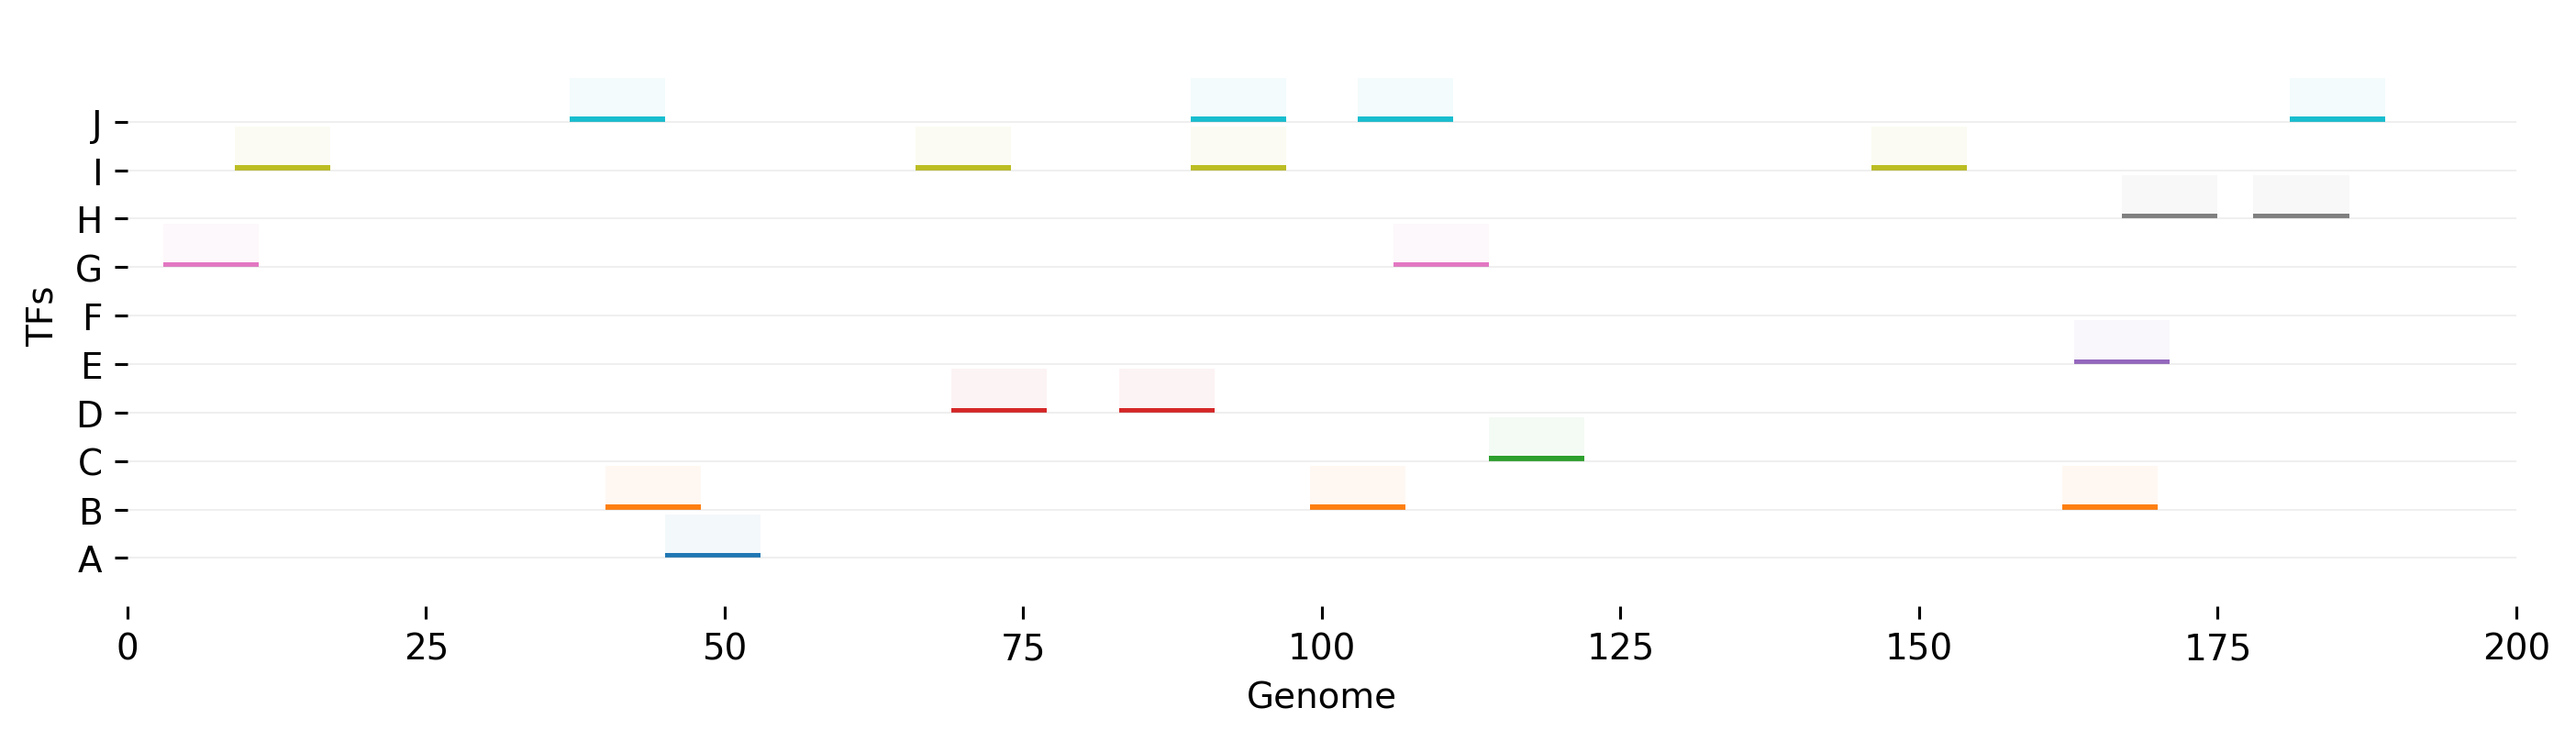

In [6]:
ax = draw_config(TFBSs)

In [7]:
# TF_concs = {'A': 100, 'B': 100}

# # config is a list of [0, 1] floats, indexing into TFBSs. It's associated with a probability
# config = [1., 1.]


In [8]:
def exact_computation(config):

    enumerate_configs(TFBSs)
    Z(TFBSs, TF_concs)

In [7]:
# want a function which takes [TF] concentrations and TF binding sites and tells you the probability of each configuation

def :
    pass

def :

    return [P_config(config) for config in enumerate_configs(TFBSs)]



def energy(TFBSs, TF_concs):
    pass
    # energy of binding of each occupied TFBS
    # energy of cooperativity between each bound TFBS
    # energy of competition between each bound TFBS
    # energy of competition between each bound TFBS and the nucleosome
    # energy of every unbound TF in solution


def multiplicity(TFBSs, TF_concs):
    pass




**References**: 
- [Transcriptional regulation by the numbers: models](https://pubmed.ncbi.nlm.nih.gov/15797194/)

### Competitive binding

### Indirect cooperativity

### Putting it all together

## Conditioning on ATAC